Code for implementing VQVAE for CMPM280G seminar
References: Adam's Google Colab notebook

In [2]:
from pylab import *
import tensorflow as tf
print(tf.config.list_physical_devices())

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# MNIST input data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(f"x: {x_train.shape}@{x_train.dtype},\ny: {y_train.shape}@{y_train.dtype}")

x: (60000, 28, 28)@uint8,
y: (60000,)@uint8


In [40]:
# Create a list of 32 images, each 28x28 pixels
grid_x = np.ndarray(shape=(32,28,28), dtype=uint8, order='F') 
for i in range(32):
    grid_x[i] = x_train[i]
print(grid_x.shape)

(32, 28, 28)


In [74]:
# Define the encoder class
class Encoder:
  def __init__(self):
    self.network = tf.keras.models.Sequential(
      [
        tf.keras.layers.Input(shape=(32,28,28)),
        tf.keras.layers.Reshape((32,28,28,1)),
        tf.keras.layers.Conv2D(
          32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(32,28,28,1)),
        tf.keras.layers.Conv2D(
          16, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(32,28,28,1)),
        tf.keras.layers.Conv2D(
        8, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(32,28,28,1)),
        tf.keras.layers.Reshape((32,128)),
        tf.keras.layers.Dense(32), #the bottleneck dimension          
      ], name='encoder')

encoder = Encoder()
encoder.network.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_38 (Reshape)         (None, 32, 28, 28, 1)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 14, 14, 32)    320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 7, 7, 16)      4624      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 4, 4, 8)       1160      
_________________________________________________________________
reshape_39 (Reshape)         (None, 32, 128)           0         
_________________________________________________________________
dense_34 (Dense)             (None, 32, 32)            4128      
Total params: 10,232
Trainable params: 10,232
Non-trainable params: 0
_______________________________________________________

In [73]:
# Define the decoder class
class Decoder:
    def __init__(self):
        self.network = tf.keras.models.Sequential(
      [
        tf.keras.layers.Input(shape=(32,32)),
        tf.keras.layers.Dense((128)), #32x128 output
        tf.keras.layers.Reshape((32,16,8,1)),
        tf.keras.layers.Conv2DTranspose(
          8, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(
          16, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(
        32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
         #tf.keras.layers.Conv2DTranspose(
        #1, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        
        #Make 32x32x1 into 28x28x1 (crop 2 values out)
        #tf.keras.layers.Cropping2D(((2,2),(2,2))), 
        #tf.keras.layers.Reshape((32,28,28)),           
      ], name='decoder')

decoder = Decoder()
decoder.network.summary()   
    

ValueError: Inputs should have rank 4. Received input shape: (None, 32, 1, 16, 8)

In [6]:
# The autoencoder network
class Autoencoder:
    def __init__(self, encoder, decoder):
        self.network = tf.keras.models.Sequential(
            [
                tf.keras.Input(shape=(28, 28)),
                encoder,
                decoder,
            ], name='autoencoder'
        )
autoencoder = Autoencoder(encoder.network, decoder.network)
ae = autoencoder.network

In [8]:
#Configure the model for training and then train
ae.compile(loss='MSE')
ae.fit(x_train, x_train, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 20s 10ms/step - loss: 592.9820
Epoch 2/50
1875/1875 [==============================] - 19s 10ms/step - loss: 557.3232
Epoch 3/50
1875/1875 [==============================] - 19s 10ms/step - loss: 531.8751
Epoch 4/50
1875/1875 [==============================] - 19s 10ms/step - loss: 512.2758
Epoch 5/50
1875/1875 [==============================] - 19s 10ms/step - loss: 496.5042
Epoch 6/50
1875/1875 [==============================] - 19s 10ms/step - loss: 483.9467
Epoch 7/50
1875/1875 [==============================] - 18s 9ms/step - loss: 473.3253
Epoch 8/50
1875/1875 [==============================] - 18s 10ms/step - loss: 464.7919
Epoch 9/50
1875/1875 [==============================] - 19s 10ms/step - loss: 457.4722
Epoch 10/50
1875/1875 [==============================] - 18s 10ms/step - loss: 450.6768
Epoch 11/50
1875/1875 [==============================] - 18s 10ms/step - loss: 445.1603
Epoch 12/50
1875/1875 [===================

KeyboardInterrupt: 

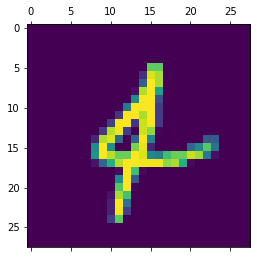

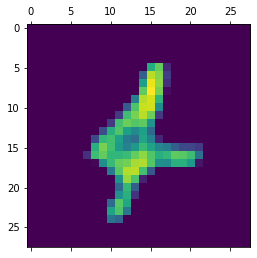

In [56]:
#Check if it works
matshow(x_test[300])
matshow((ae.predict(x_test[300][None]))[0])

In [28]:
# Code taken and modified from https://github.com/HenningBuhl/VQ-VAE_Keras_Implementation/blob/master/VQ_VAE_Keras_MNIST_Example.ipynb by Github user HenningBuhl and Adam's Colab notebook
class vectorQuantizerLayer(tf.keras.layers.Layer):
    def __init__(self, codebook_dim, codebook_number, initializer='uniform'):
        super(vectorQuantizerLayer, self).__init__()
        self.codebook_dim = codebook_dim
        self.codebook_number = codebook_number
        self.codebook = self.add_weight(
            shape=(codebook_dim, codebook_number), 
            initializer=initializer,
            trainable=True)

    def call(self, x):
        # Reshape the input according to the codebook vector dimensions
        reshaped_x = tf.keras.backend.reshape(x, (-1,self.codebook_dim))
        print(reshaped_x)

        # Calculate eucledian distances of the input to the codebook vectors. This is basically (a-b)^2 = a^2 + 2*a*b + b^2 in matrix form. 
        distances = (
            tf.keras.backend.sum(reshaped_x**2, axis=1, keepdims=True) 
                - 2*tf.keras.backend.dot(reshaped_x, self.codebook) 
                + tf.keras.backend.sum(self.codebook**2, axis=0, keepdims=True))

        # Identify the codebook indices with minimum distances
        codebook_indices = tf.keras.backend.argmin(distances, axis=1)
        codebook = tf.keras.backend.one_hot(
            self.codebook_indices, self.codebook_number)
        


vq = vectorQuantizerLayer(32, 10)
vq.call(encoder.network.predict(x_train[300][None]))

tf.Tensor(
[[  2.6055305    0.5632467   -1.0642121   -3.342974   -12.923257
    1.1507467   16.59071     -7.6365547   -3.9686325    0.91133064
   -5.4568214  -21.117762     3.2623506    3.8224304   -3.0173602
    9.845684    -7.9742866    0.24661547   1.1035298   17.233839
    3.2453508   -7.1569214   12.78334      2.3388686   -4.859659
   -6.235891     6.510942    -3.349485     6.0059195   -2.9175406
   -1.6749318   -6.7419596 ]], shape=(1, 32), dtype=float32)
Shape of distance vector is: (1, 10)
